# Import and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy import special
import math
import time as toc
import import_ipynb
import os


os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
from SpatialTemporal_Correlation_and_Convolution import STcorrelate
from SpatialTemporal_Correlation_and_Convolution import STconvolve
%matplotlib inline

importing Jupyter notebook from SpatialTemporal_Correlation_and_Convolution.ipynb


In [2]:
def Gaussian(x,s):
    return(np.exp(-(x/s)**2))/s/np.sqrt(np.pi)

In [3]:
def Retina_Mechine_1D(stimulus, sigma_dict, para_dict, dx, dt, loc_dict = 1):
    if loc_dict == 1:
        loc_dict = {}
        loc_dict['C'] = 1
        loc_dict['H'] = 1
        
    klen = max(sigma_dict.values())*5
    xx = np.arange(-klen,klen,dx)
    KC = Gaussian(xx,sigma_dict['C'])
    KH = Gaussian(xx,sigma_dict['H'])

    output = np.zeros_like(stimulus)#y output
    zts = np.zeros_like(stimulus)#horizontal
    sstm = np.zeros_like(stimulus)
    rpeak = np.zeros(np.shape(stimulus)[0])
    
    if 'tau_y' in sigma_dict.keys():
        T = np.arange(0,int(sigma_dict['tau_y']/dt*8))*dt
        Ky=T/sigma_dict['tau_y'] /sigma_dict['tau_y'] *np.exp(-T/sigma_dict['tau_y'])
#         plt.plot(T,Ky)
        for j in range(np.shape(stimulus)[1]):
            for i in range(len(Ky)-1):
                for ii in range(i+1):
                    sstm[i,j] += stimulus[ii,j]*Ky[i-ii]*dt
            sx = np.convolve(stimulus[:,j],Ky,'valid')*dt
            sstm[len(Ky)-1:,j] = sx.copy()
    else:
        sstm = stimulus.copy()

    for i in range(np.shape(stimulus)[0]-1):
        s = sstm[i,:]
        rs = np.convolve(s,KC,'same')*dx
        ry = np.convolve(output[i,:],KH,'same')*dx  # feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        rz = np.convolve(zts[i,:],KH,'same')*dx     # feedback from horizontal cell (z convoluted with horitonatl cell receptive field KH)

        dyj =(-para_dict['alpha']*output[i,:]+para_dict['k']*(rs-para_dict['phi']*rz))
        dzj =(-para_dict['beta']*zts[i,:]+para_dict['g']*output[i,:])
        output[i+1,:] = (output[i,:]+dyj*dt)*loc_dict['C']
        zts[i+1,:] = (zts[i,:]+dzj*dt)*loc_dict['H']
        
        maxpos = np.argmax(output[i+1,:])
        rpeak[i+1]= maxpos*dx
    return output, zts, rpeak

def FB_FF_1l_1D(stimulus, sigma_dict, para_dict, dx, dt, loc_dict = 1, noiseamount=0):
    if loc_dict == 1:
        loc_dict = {}
        loc_dict['C'] = 1
        loc_dict['H'] = 1
        
    klen = max(sigma_dict.values())*3
    xx = np.arange(-klen,klen+dx,dx)
    KC = Gaussian(xx,sigma_dict['C'])
    KH = Gaussian(xx,sigma_dict['H'])
    KB = Gaussian(xx,sigma_dict['B'])
    plt.plot(KC)
    plt.plot(KH)
    plt.plot(KB)
    
    output = np.zeros_like(stimulus)#y output
    zts = np.zeros_like(stimulus)#horizontal
    yts = np.zeros_like(stimulus)#horizontal
    wts = np.zeros_like(stimulus)#horizontal
    sstm = np.zeros_like(stimulus)
    rpeak = np.zeros(np.shape(stimulus)[0])
    
    if 'tau_y' in sigma_dict.keys():
        T = np.arange(0,int(sigma_dict['tau_y']/dt*8))*dt
        Ky=T/sigma_dict['tau_y'] /sigma_dict['tau_y'] *np.exp(-T/sigma_dict['tau_y'])
        for j in range(np.shape(stimulus)[1]):
            for i in range(len(Ky)-1):
                for ii in range(i+1):
                    sstm[i,j] += stimulus[ii,j]*Ky[i-ii]*dt
            sx = np.convolve(stimulus[:,j],Ky,'valid')*dt
            sstm[len(Ky)-1:,j] = sx.copy()
    else:
        sstm = stimulus.copy()

    for i in range(np.shape(stimulus)[0]-1):
        s = sstm[i,:]
        rs = np.convolve(s,KC,'same')*dx
        ry = np.convolve(yts[i,:],KB,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        rz = np.convolve(zts[i,:],KH,'same')*dx# feedback from horizontal cell (z convoluted with horitonatl cell receptive field KH)

        dyj =(-para_dict['alpha']*yts[i,:]+para_dict['k']*(rs-para_dict['phi']*rz))*dt
        dzj =(-para_dict['beta']*zts[i,:]+para_dict['g']*yts[i,:])*dt
        dwj =(-para_dict['gramma']*wts[i,:]+para_dict['p']*(ry-para_dict['psy']*rz))*dt
        
        noise = para_dict['k']/para_dict['alpha']*np.mean(rs)*np.random.randn(len(dyj))*noiseamount
        yts[i+1,:] = (yts[i,:]+dyj+noise)*loc_dict['C']
        zts[i+1,:] = (zts[i,:]+dzj)*loc_dict['H']
        wts[i+1,:] = (wts[i,:]+dwj)
        maxpos = np.argmax(wts[i+1,:])
        rpeak[i+1]= maxpos*dx
    return wts, zts, yts, rpeak

In [4]:
def STA(r, x, dt, window):
    negshift=round(window[0]/dt) # second
    posshift=round(window[1]/dt) # second
    xSTS = np.zeros(posshift-negshift)
    for i in np.arange(-negshift, len(r)-posshift):
        xSTS = xSTS + x[i+negshift:i+posshift]*r[i]
        
    xSTA = xSTS/sum(r[-negshift:len(r)-posshift])
    time = np.arange(negshift*dt, posshift*dt, dt)
    return time, xSTA

In [5]:
def Ay(para_dict, sigma_dict, x, n = 1000):
    alpha = para_dict['alpha']
    beta = para_dict['beta']
    k = para_dict['k']
    phi = para_dict['phi']
    g = para_dict['g']
    sigma_h = sigma_dict['H']
    sigma_c = sigma_dict['C']
    ans =  0
    for i in range(n+1):
        ans += k/alpha/np.sqrt(np.pi)*(-k*g/alpha/beta)**i/np.sqrt(sigma_c**2+i*sigma_h**2)*np.exp(-x**2/(sigma_c**2+i*sigma_h**2))
    return ans

# Setting parameters

## CKC's parameters

In [6]:
filename = 'CKC\'s STkernels-good parameters'

sigma_dict = dict()
sigma_dict['H'] = 1
sigma_dict['C'] = sigma_dict['H']*0.2 # RF size of cone cell
dx = sigma_dict['H']/40.

dt=0.01  #large dt will cause  overflow
sigma_dict['tau_y'] = 0.02

#Width setting
xlen = 50*sigma_dict['H'] #spatial extend of simulation
hw = 0.6*sigma_dict['H']#half bar width
tempx = np.arange(0,xlen+dx,dx)

para_dict = {}
para_dict['alpha'] = 40.
para_dict['beta'] = 2.
para_dict['k'] = 40.
para_dict['phi'] = 5.
para_dict['g'] = 2.

para_dict['gramma'] = 10.
para_dict['p'] = 10.
para_dict['psy'] = 0.1
sigma_dict['B'] = sigma_dict['H']*1.5

para_dict['g']*para_dict['k']*para_dict['phi']/para_dict['alpha']/para_dict['beta']

5.0

## Leo's parameters

In [7]:
# filename = 'Leo\'s STkernels-good parameters'

# sigma_dict = dict()
# sigma_dict['H'] = 1
# sigma_dict['C'] = sigma_dict['H']*0.75 # RF size of cone cell
# dx = sigma_dict['H']/40.

# dt=0.01  #large dt will cause  overflow
# sigma_dict['tau_y'] = 0.02

# #Width setting
# xlen = 50*sigma_dict['H'] #spatial extend of simulation
# hw = 0.6*sigma_dict['H']#half bar width
# tempx = np.arange(0,xlen+dx,dx)

# para_dict = {}
# para_dict['alpha'] = 40.
# para_dict['beta'] = 2.
# para_dict['k'] = 50.
# para_dict['phi'] = 20.
# para_dict['g'] = 2.

# para_dict['g']*para_dict['k']*para_dict['phi']/para_dict['alpha']/para_dict['beta']

In [8]:
# #plot analytic result
# x = np.arange(-int(xlen/dx/2),int(xlen/dx/2))*dx
# plt.plot(Ay(para_dict,sigma_dict,x))
# plt.title('Show Analitc Solution of Steady State')

# Whole Field STA

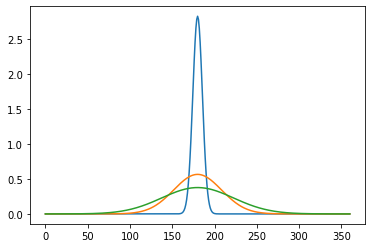

In [9]:
homo_cSTA = np.matmul((np.random.randn(10000)*0.03+0.1)[:, np.newaxis], np.ones(int(xlen/dx)+1)[np.newaxis, :])
wts, zts, yts, _ = FB_FF_1l_1D(homo_cSTA, sigma_dict, para_dict, dx, dt)
csta_output = wts

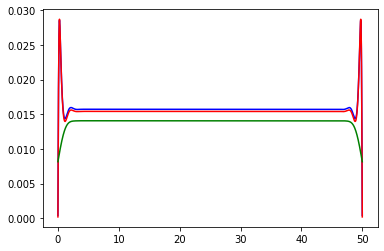

In [10]:
#####PLot numerical solution########
plt.plot(tempx,yts.T[:,-1],'b')#numerical solution
plt.plot(tempx,zts.T[:,-1],'r')#numerical solution
plt.plot(tempx,wts.T[:,-1],'g')#numerical solution

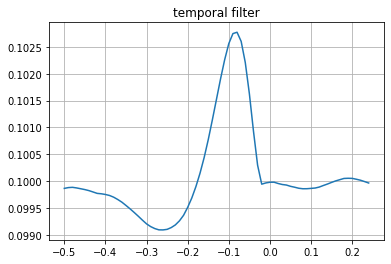

In [11]:
output = csta_output[:,int(xlen/dx/2)]
time, xSTA = STA(output, homo_cSTA[:,0], dt, [-0.5,0.25])
plt.plot(time, xSTA)
plt.title('temporal filter')
plt.grid()

# A Smooth Constant speed Moving Bar

In [12]:
nstep = int(1.6/dt)
moving_bar = np.zeros([nstep, int(xlen/dx)+1])
pos = 0
v = 2.5*hw/dx #sstep/s
pos = 600
speak = np.zeros(nstep)
for i in range(nstep):
    pos = pos+v*dt
    moving_bar[i,max(int(round(pos-hw/dx)), 0):min(int(round(pos+hw/dx)), int(xlen/dx))] = 1
    speak[i] = pos*dx

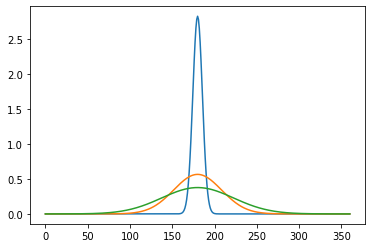

In [13]:
wts, zts, yts, rpeak = FB_FF_1l_1D(moving_bar, sigma_dict, para_dict, dx, dt)
SbS_output = wts

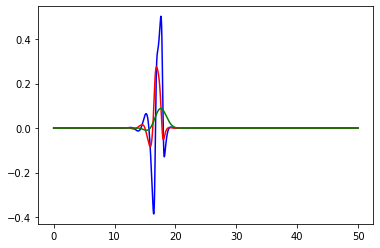

In [14]:
#####PLot numerical solution########
plt.plot(tempx,yts.T[:,-1],'b')#numerical solution
plt.plot(tempx,zts.T[:,-1],'r')#numerical solution
plt.plot(tempx,wts.T[:,-1],'g')#numerical solution

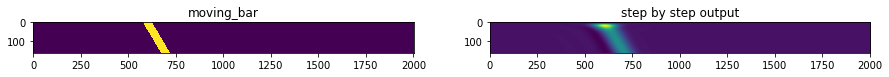

In [15]:
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2)
ax2.imshow(moving_bar)
ax2.set_title('moving_bar')
ax3.imshow(SbS_output)
ax3.set_title('step by step output')
fig.set_size_inches(15, 5)

Text(0.5, 1.0, 'prediction')

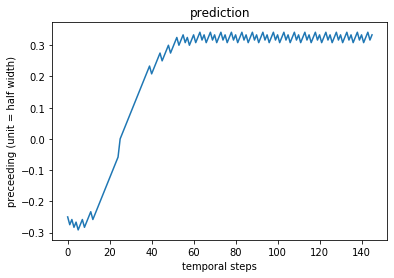

In [16]:
plt.plot(((rpeak-speak)/hw)[14:])
# plt.xlim([100,nstep])
# plt.ylim([-hw,+hw])
plt.ylabel('preceeding (unit = half width)')
plt.xlabel('temporal steps')
plt.title('prediction')

# spatial-temporal Checker 

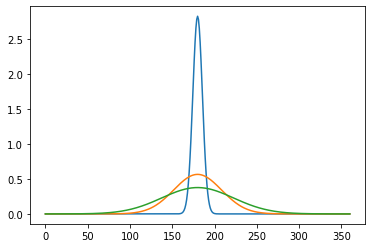

In [17]:
nstep = 5000
ST_cSTA = np.random.randn(nstep, int(xlen/dx)+1)*0.3
ST_cSTA = ST_cSTA-np.min(ST_cSTA)+1
wts, zts, yts, _ = FB_FF_1l_1D(ST_cSTA, sigma_dict, para_dict, dx, dt)
stcsta_output = wts[:,int(sigma_dict['B']/dx):int(-sigma_dict['B']/dx)]

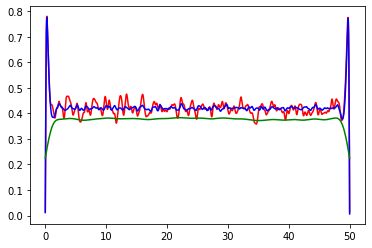

In [18]:
#####PLot numerical solution########
plt.plot(tempx,yts.T[:,-1],'r')#numerical solution
plt.plot(tempx,zts.T[:,-1],'b')#numerical solution
plt.plot(tempx,wts.T[:,-1],'g')#numerical solution

In [19]:
tic = toc.time()
time_window = [-0.5,0.1]
step = np.round(np.arange(time_window[0],time_window[1],dt)/dt).astype(int)
test2, (time_axis, space_axis) = STcorrelate(ST_cSTA, stcsta_output,step,dx,dt)
toc.time()-tic

100.99094128608704

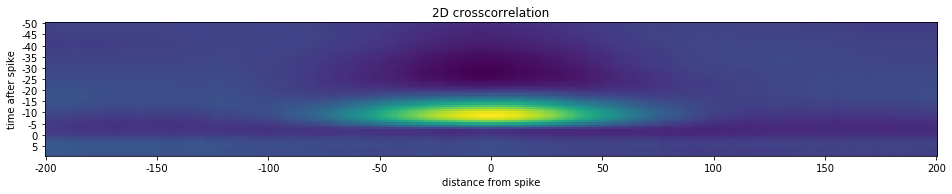

In [20]:
space_window = np.arange(-int(xlen/dx/10),1+int(xlen/dx/10))
fig, ax2 = plt.subplots(nrows=1, ncols=1)
ax2.imshow((test2)[:,space_window+int(xlen/dx/2)+1])
ax2.set_yticks(np.arange(0,len(step),5))
ax2.set_yticklabels(step[np.arange(0,len(step),5)])
ax2.set_ylabel('time after spike')
ax2.set_xticks(np.arange(0,len(space_window),50))
ax2.set_xticklabels(space_window[np.arange(0,len(space_window),50)])
ax2.set_xlabel('distance from spike')
ax2.set_title('2D crosscorrelation')
fig = plt.gcf()
fig.set_size_inches(16, 10)

choose center cell and a certain time before spike

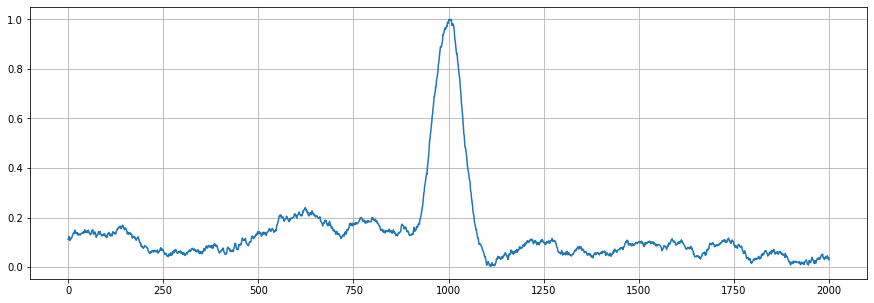

In [37]:
tbs_i = 35
plt.plot(test2[tbs_i, :]/max(test2[tbs_i, :]))
plt.grid()
fig = plt.gcf()
fig.set_size_inches(15, 5)

In [22]:
ST_kernel2 = []
for i in np.arange(0,np.argmin(np.abs(step))):
    ST_kernel2.append(test2[i,:]+np.flip(test2[i,:]))
ST_kernel2 = np.flipud(np.array(ST_kernel2)/2)

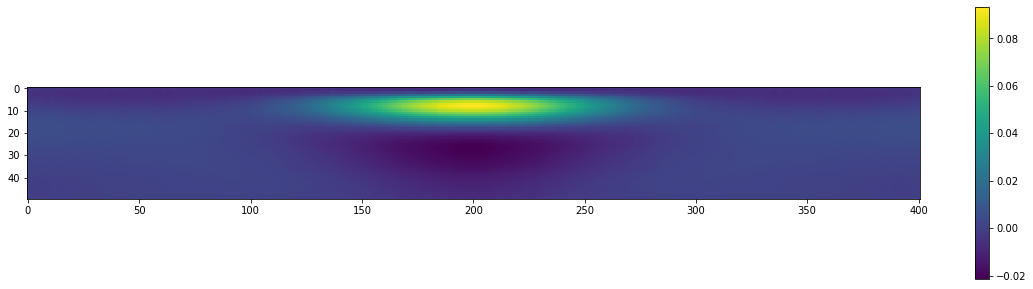

In [23]:
ST_kernel = ST_kernel2[:, space_window+int(xlen/dx/2)+1]
plt.imshow(ST_kernel)
plt.colorbar()
fig = plt.gcf()
fig.set_size_inches(20, 5)

# Simply apply spatial-temporal kernel on moving bar

In [24]:
tic = toc.time()
mb_y = STconvolve(moving_bar,ST_kernel,dx,dt)
toc.time()-tic

0.8148210048675537

In [25]:
#1d scipy.signal.convolve much slower than numpy.convolve (https://github.com/scipy/scipy/issues/5280)
# STK = np.concatenate((np.zeros_like(ST_kernel),ST_kernel), axis = 0)
# np.shape(STK)
# tic = toc.time()
# nstep = 1600
# con2d_y = signal.convolve2d(moving_bar.T, STK.T,  mode='same')
# print(toc.time()-tic)
# plt.imshow(con2d_y.T)

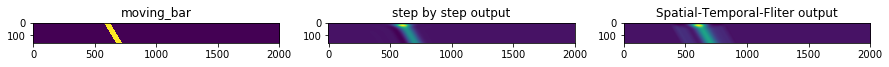

In [26]:
fig, (ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=3) 
ax2.imshow(moving_bar)
ax2.set_title('moving_bar')
ax3.imshow(SbS_output)
ax3.set_title('step by step output')
ax4.imshow(mb_y)
ax4.set_title('Spatial-Temporal-Fliter output')
fig.set_size_inches(15, 15)

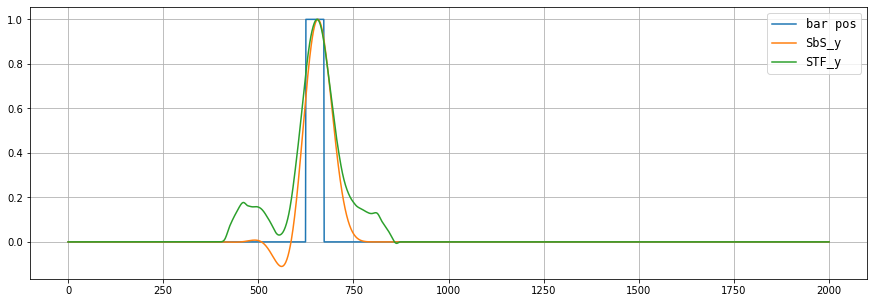

In [27]:
index = int(moving_bar.shape[0]/2)
plt.plot(moving_bar[index,:])
plt.plot(SbS_output[index,:]/max(SbS_output[index,:]))
plt.plot(mb_y[index,:]/max(mb_y[index,:]))
# plt.plot(con2d_y[1000,:]/max(con2d_y[1000,:]))
plt.grid()
fig = plt.gcf()
plt.legend( ('bar pos', 'SbS_y', 'STF_y'), loc='best', prop={'size': 'large', 'family': 'monospace'})
# plt.xlim([1050,1600])
fig.set_size_inches(15, 5)

# Apply SVD on Spatial-Temporal Kernel

In [28]:
from numpy import linalg as la
U,sigma,VT=la.svd(ST_kernel)

In [29]:
sigma/sum(sigma)

array([8.17386090e-01, 1.20629275e-01, 4.79588211e-02, 8.18959598e-03,
       2.32531207e-03, 1.19239689e-03, 9.73532623e-04, 4.14102465e-04,
       1.87032545e-04, 1.59669052e-04, 1.23263505e-04, 8.31264121e-05,
       5.83234725e-05, 4.48397329e-05, 3.40951283e-05, 2.72808811e-05,
       2.07339067e-05, 1.68061213e-05, 1.56099246e-05, 1.32867293e-05,
       1.17643007e-05, 1.07209936e-05, 9.89214463e-06, 9.19021544e-06,
       8.31175487e-06, 7.62940511e-06, 7.40983691e-06, 6.78651440e-06,
       6.05611148e-06, 5.82756052e-06, 5.02132910e-06, 4.46347757e-06,
       4.25728872e-06, 4.19022025e-06, 3.88355253e-06, 3.76880316e-06,
       3.53626507e-06, 3.44605962e-06, 3.26295636e-06, 3.15927959e-06,
       3.08176772e-06, 3.00730667e-06, 2.75365007e-06, 2.60918743e-06,
       2.52591163e-06, 2.32461061e-06, 2.24856968e-06, 1.96026870e-06,
       1.86604239e-06, 1.85173769e-06])

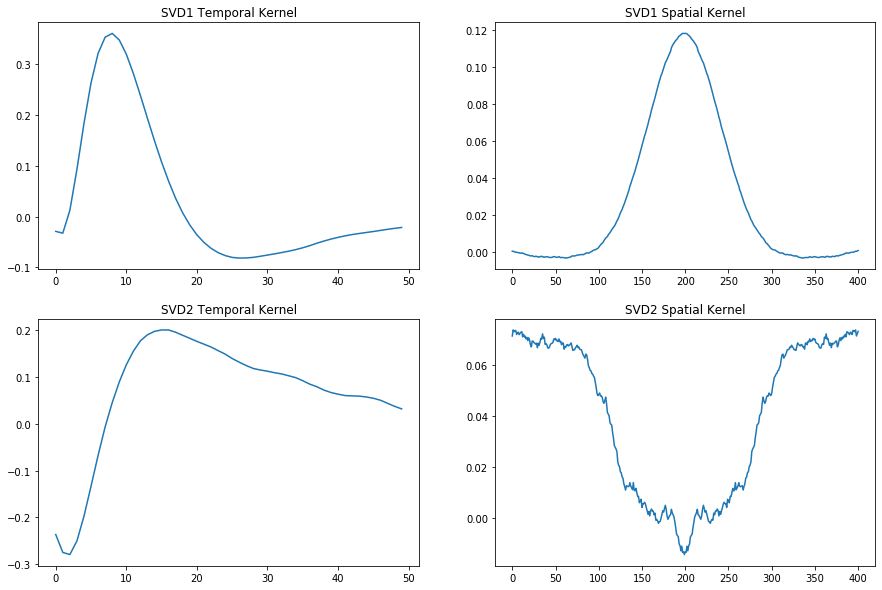

In [30]:
fig, ((ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=2, ncols=2)
ax2.plot(U[:,0])
ax2.set_title('SVD1 Temporal Kernel')
ax3.plot(VT[0,:])
ax3.set_title('SVD1 Spatial Kernel')
ax4.plot(U[:,1])
ax4.set_title('SVD2 Temporal Kernel')
ax5.plot(VT[1,:])
ax5.set_title('SVD2 Spatial Kernel')
fig.set_size_inches(15, 10)

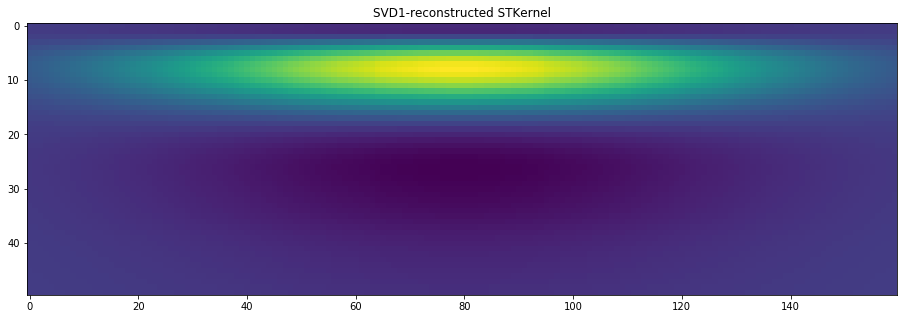

In [31]:
cSVD = 0
SVD_STkernel = np.matmul(U[:,cSVD][:, np.newaxis], VT[cSVD,:][np.newaxis, :])
plt.imshow(SVD_STkernel[:,int(ST_kernel.shape[1]*0.3):int(ST_kernel.shape[1]*0.7)])
plt.title('SVD'+str(cSVD+1)+'-reconstructed STKernel')
fig = plt.gcf()
fig.set_size_inches(20, 5)

In [32]:
nstep = 160
SVD_STK_y = np.zeros([nstep, int(xlen/dx)+1])
for i in range(nstep):
    for ii in range(i):
        if (i-ii) < np.shape(ST_kernel)[0]:
            SVD_STK_y[i,:] += np.convolve(moving_bar[ii,:],SVD_STkernel[i-ii, :], 'same')

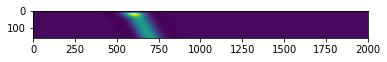

In [33]:
plt.imshow(SVD_STK_y)

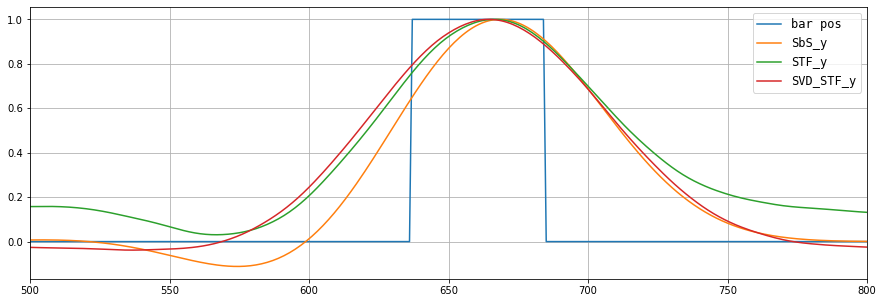

In [34]:
plt.plot(moving_bar[100,:])
plt.plot(SbS_output[100,:]/max(SbS_output[100,:]))
plt.plot(mb_y[100,:]/max(mb_y[100,:]))
plt.plot(SVD_STK_y[100,:]/max(SVD_STK_y[100,:]))
# plt.plot(-SVD_STK_y[100,:]/min(SVD_STK_y[100,:]))
plt.grid()
fig = plt.gcf()
plt.legend( ('bar pos', 'SbS_y', 'STF_y', 'SVD_STF_y'), loc='best', prop={'size': 'large', 'family': 'monospace'})
plt.xlim([500,800])
fig.set_size_inches(15, 5)

# Save STkernel

In [35]:
# np.savez(filename, ST_kernel=ST_kernel ,time_axis=step*dt, para_dict=para_dict, sigma_dict=sigma_dict, dx=dx, dt=dt)